# Met Éireann Reanalysis - dealing with missing data

In [1]:
import glob
import os
from datetime import datetime, timezone
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import climag.climag as cplt

In [2]:
# directory of processed MÉRA netCDF files
DATA_DIR = os.path.join("/run/media/nms/MyPassport", "MERA", "netcdf_day")

## Find timestamps with missing data

In [3]:
ds_grib = xr.open_dataset(
    "/run/media/nms/MyPassport/MERA/grib/117_105_0_4_FC3hr/"
    "MERA_PRODYEAR_2013_05_117_105_0_4_FC3hr",
    chunks="auto",
    decode_coords="all",
    engine="cfgrib",
)

In [4]:
ds_grib

<xarray.Dataset>
Dimensions:            (time: 128, step: 3, y: 489, x: 529)
Coordinates:
  * time               (time) datetime64[ns] 2013-05-01 ... 2013-05-16T21:00:00
  * step               (step) timedelta64[ns] 01:00:00 02:00:00 03:00:00
    heightAboveGround  float64 ...
    latitude           (y, x) float64 dask.array<chunksize=(489, 529), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(489, 529), meta=np.ndarray>
    valid_time         (time, step) datetime64[ns] dask.array<chunksize=(128, 3), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    grad               (time, step, y, x) float32 dask.array<chunksize=(101, 2, 390, 422), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             eidb
    GRIB_centreDescription:  Dublin
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Dublin
    history:                 2023-04-18T15:55 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
ds_nc = xr.open_dataset(
    "/run/media/nms/MyPassport/MERA/netcdf/117_105_0_4_FC3hr/"
    "MERA_PRODYEAR_2013_05_117_105_0_4_FC3hr.nc",
    chunks="auto",
    decode_coords="all",
)

In [6]:
ds_nc

<xarray.Dataset>
Dimensions:            (time: 128, x: 158, y: 166, height: 1)
Coordinates:
  * time               (time) datetime64[ns] 2013-05-01 ... 2013-05-16T21:00:00
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
  * height             (height) float64 0.0
    spatial_ref        int64 ...
    Lambert_Conformal  int64 ...
Data variables:
    grad               (time, height, y, x) float32 dask.array<chunksize=(128, 1, 166, 158), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Apr 15 21:05:39 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

## Read radiation daily data

In [5]:
ds = xr.open_dataset(
    os.path.join(DATA_DIR, "MERA_117_105_0_4_day.nc"),
    chunks="auto",
    decode_coords="all",
)
ds = ds.isel(height=0)

In [6]:
ds2 = xr.open_dataset(
    os.path.join(DATA_DIR, "MERA_111_105_0_4_day.nc"),
    chunks="auto",
    decode_coords="all",
)
ds2 = ds2.isel(height=0)

In [9]:
ds

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 2800)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
  * time               (time) datetime64[ns] 2012-01-01 ... 2019-08-31
    Lambert_Conformal  int64 ...
    spatial_ref        int64 ...
Data variables:
    grad               (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Apr 15 21:01:13 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [10]:
ds2

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 2800)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 2012-01-01 ... 2019-08-31
    spatial_ref        int64 ...
Data variables:
    nswrs              (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Apr 14 14:07:36 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

## Visualise

In [7]:
# Moorepark, Fermoy met station coords
LON, LAT = -8.26389, 52.16389

In [8]:
# transform coordinates from lon/lat to Lambert Conformal Conic
XLON, YLAT = cplt.projection_lambert_conformal.transform_point(
    x=LON, y=LAT, src_crs=ccrs.PlateCarree()
)

In [9]:
def plot_map(data, var, cmap="Spectral_r"):
    """
    Helper function for plotting maps
    """

    plt.figure(figsize=(9, 7))
    ax = plt.axes(projection=cplt.projection_lambert_conformal)
    data.isel(time=120)[var].plot.contourf(
        ax=ax,
        robust=True,
        x="x",
        y="y",
        levels=10,
        transform=cplt.projection_lambert_conformal,
        cmap=cmap,
        cbar_kwargs={
            "label": (
                data[var].attrs["long_name"]
                + " ["
                + data[var].attrs["units"]
                + "]"
            )
        },
    )
    ax.gridlines(
        draw_labels=dict(bottom="x", left="y"),
        color="lightslategrey",
        linewidth=0.5,
        x_inline=False,
        y_inline=False,
    )
    ax.coastlines(resolution="10m", color="darkslategrey", linewidth=0.75)
    ax.set_title(str(data.isel(time=90)["time"].values))
    plt.tight_layout()
    plt.show()

In [10]:
def plot_ts(data, var, sub=True):
    """
    Helper function for plotting time series
    """

    plt.figure(figsize=(12, 4))
    data_ts = data.sel({"x": XLON, "y": YLAT}, method="nearest")
    if sub:
        data_ts = data_ts.sel(time=slice("2013-04", "2013-06"))
    plt.plot(data_ts["time"], data_ts[var])
    # plt.title(
    #     data[var].attrs["long_name"] + " [" + data[var].attrs["units"] + "]"
    # )
    plt.tight_layout()
    plt.show()

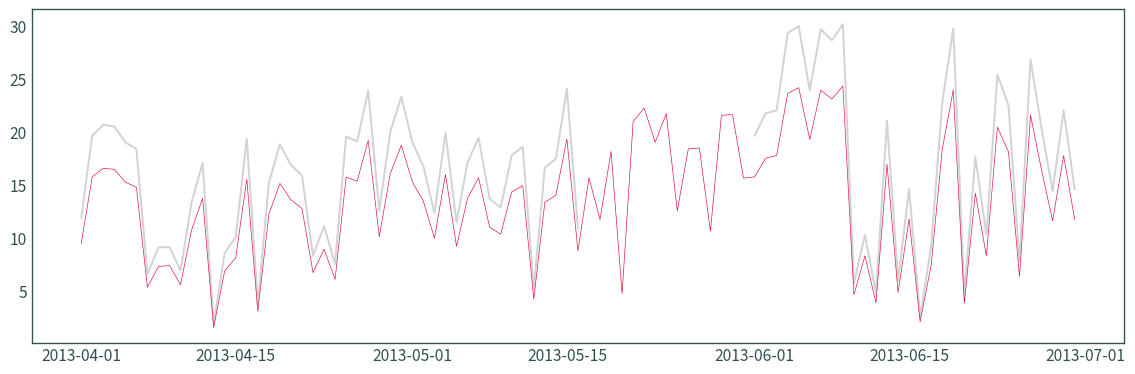

In [15]:
ds_ = ds.sel({"x": XLON, "y": YLAT}, method="nearest")
ds2_ = ds2.sel({"x": XLON, "y": YLAT}, method="nearest")
ds_ = ds_.sel(time=slice("2013-04", "2013-06"))
ds2_ = ds2_.sel(time=slice("2013-04", "2013-06"))
fig = plt.figure(figsize=(12, 4))
plt.plot(ds_["time"], ds_["grad"], color="lightgrey")
plt.plot(ds2_["time"], ds2_["nswrs"], color="crimson", linewidth=0.5)

# plt.title(
#     data[var].attrs["long_name"] + " [" + data[var].attrs["units"] + "]"
# )
plt.tight_layout()
plt.show()

## Ratio

In [34]:
ds3 = ds.copy()
ds3 = ds3.assign(nswrs=ds2["nswrs"])
ds3 = ds3.assign(ratio=ds3["grad"] / ds3["nswrs"])

In [35]:
ds3

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 2800)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
  * time               (time) datetime64[ns] 2012-01-01 ... 2019-08-31
    Lambert_Conformal  int64 ...
    spatial_ref        int64 ...
Data variables:
    grad               (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
    nswrs              (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
    ratio              (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Apr 15 21:01:13 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

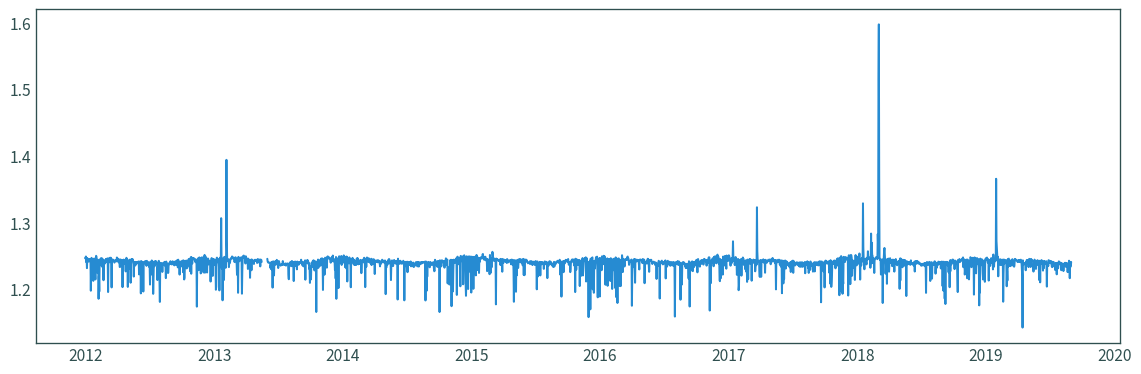

In [36]:
ds3_ = ds3.sel({"x": XLON, "y": YLAT}, method="nearest")
# ds3_ = ds3_.sel(time=slice("2013-04", "2013-06"))
fig = plt.figure(figsize=(12, 4))
plt.plot(ds3_["time"], ds3_["ratio"])
plt.tight_layout()
plt.show()

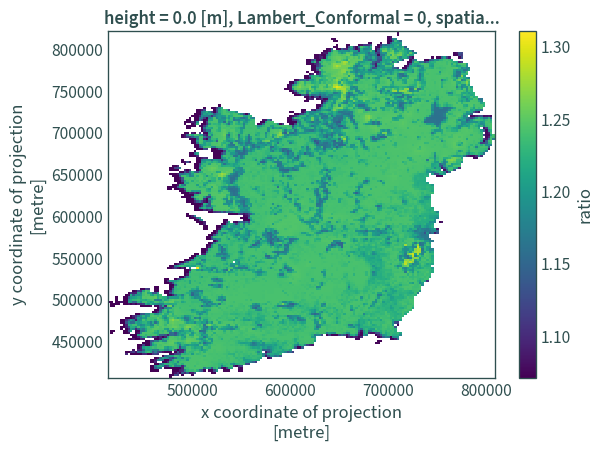

In [37]:
ds3.mean(dim="time")["ratio"].plot()
plt.tight_layout()
plt.show()

In [38]:
ds3["ratio"].mean(dim=None).values

array(1.2155399, dtype=float32)

In [39]:
(ds3["grad"] / ds3["nswrs"]).mean(dim=None).values

array(1.2155399, dtype=float32)

## Adjust

In [45]:
ds2.assign(grad=ds2["nswrs"] * 1.2155399)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 2800)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 2012-01-01 ... 2019-08-31
    spatial_ref        int64 ...
Data variables:
    nswrs              (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
    grad               (time, y, x) float32 dask.array<chunksize=(2181, 127, 121), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Apr 14 14:07:36 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [46]:
ds3 = ds3.fillna(ds2.assign(grad=ds2["nswrs"] * 1.2155399))

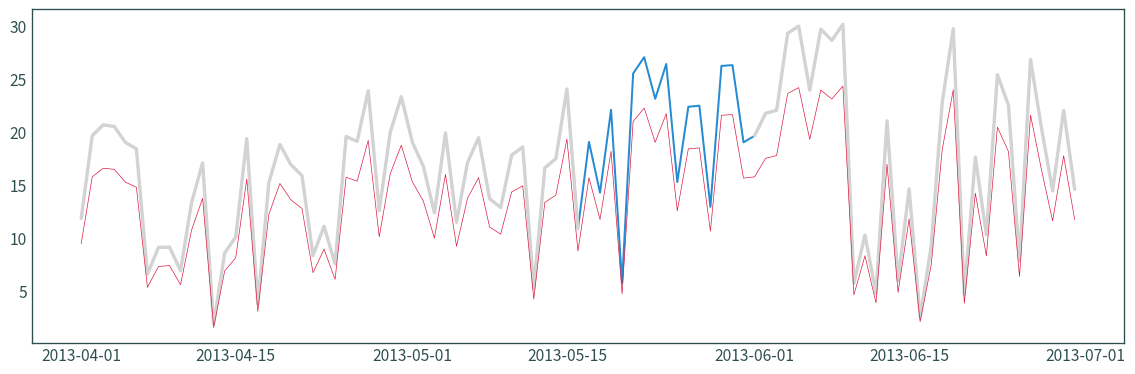

In [52]:
ds_ = ds.sel({"x": XLON, "y": YLAT}, method="nearest")
ds_ = ds_.sel(time=slice("2013-04", "2013-06"))
ds2_ = ds2.sel({"x": XLON, "y": YLAT}, method="nearest")
ds2_ = ds2_.sel(time=slice("2013-04", "2013-06"))
ds3_ = ds3.sel({"x": XLON, "y": YLAT}, method="nearest")
ds3_ = ds3_.sel(time=slice("2013-04", "2013-06"))
fig = plt.figure(figsize=(12, 4))
plt.plot(ds3_["time"], ds3_["grad"])
plt.plot(ds_["time"], ds_["grad"], color="lightgrey", linewidth=2.5)
plt.plot(ds2_["time"], ds2_["nswrs"], color="crimson", linewidth=0.5)

# plt.title(
#     data[var].attrs["long_name"] + " [" + data[var].attrs["units"] + "]"
# )
plt.tight_layout()
plt.show()